In [218]:
#we need to get a list of good matches, or a list of all matches and criteria to filter on.
#we will use open dota's API to get a list of public matches above a certain MMR.
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#gamemode 22 is all pick ranked

#r = requests.get("https://api.opendota.com/api/publicMatches?mmr_descending=6000")
r = requests.get("https://api.opendota.com/api/explorer?sql=SELECT%0A%20%20%20%20%20%20%20%20%0Amatch_id%0AFROM%20public_matches%0AWHERE%20lobby_type%20%3D%207%20AND%0Agame_mode%20%3D%2022%20AND%0Aavg_mmr%20%3E%3D%203000%0AORDER%20BY%20start_time%20DESC%0ALIMIT%202500")
#print(r.json())
matchids = [x["match_id"] for x in r.json()["rows"]]
#matches = pd.DataFrame(r.json())
#matches.set_index("match_id",inplace=True)
#matches = matches[matches["game_mode"] == 22]
#print(matchids)

In [219]:
#if we don't run this we can keep appending
big_dict = {}
bigger_dict = {}


In [220]:
import asyncio

from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport

from time import sleep
from tqdm import tqdm

async def main():
    unfinished_count = 0
    finished_count = 0

    #transport = AIOHTTPTransport(url="https://countries.trevorblades.com/graphql"
    transport = AIOHTTPTransport(url="https://api.stratz.com/graphql")
    # Using `async with` on the client will start a connection on the transport
    # and provide a `session` variable to execute queries on this connection
    async with Client(
        transport=transport, fetch_schema_from_transport=True,
    ) as session:
        
        for i in tqdm(range(10, len(matchids)+1, 10)):
            mids = list(matchids[i-10:i])
            query = gql(
            """
                 query recentMatches {{
                  matches(ids:{0}){{
                    stats {{
                      radiantNetworthLeads
                      radiantExperienceLeads
                      radiantKills
                      direKills
                      laneReport {{
                        dire {{
                          midLane {{
                            denyCount
                            meleeCount
                            neutralCount
                            rangeCount
                            siegeCount
                          }}
                          offLane {{
                            denyCount
                            meleeCount
                            neutralCount
                            rangeCount
                            siegeCount
                          }}
                          safeLane {{
                            denyCount
                            meleeCount
                            neutralCount
                            rangeCount
                            siegeCount
                          }}
                        }}
                        radiant {{
                          midLane {{
                            denyCount
                            meleeCount
                            neutralCount
                            rangeCount
                            siegeCount
                          }}
                          offLane {{
                            denyCount
                            meleeCount
                            neutralCount
                            rangeCount
                            siegeCount
                          }}
                          safeLane {{
                            denyCount
                            meleeCount
                            neutralCount
                            rangeCount
                            siegeCount
                          }}          
                        }}
                      }}
                    }}
                  }}
                }}
            """.format(mids)
            )
            results = await session.execute(query)
            #print(len(results['matches']))
            #print(finished_count)
            #print(unfinished_count)
            for mi,r in zip(mids,results["matches"]):
                if r['stats']['radiantNetworthLeads']:
                    finished_count += 1
                    big_dict[mi] = r['stats']
                    #here we convert the nexted list of dictionaries to a dictionary of dictionaries with tuples as keys for indexing. 
                    for side,a in r['stats']['laneReport'].items():
                        #print(side)
                        #print(len(a))
                        for x,minute in enumerate(a):
                            if x >= 18:
                                continue
                            for lane,b in minute.items():
                                #print(lane)
                                #print(b)
                                for count,c in b.items():
                                    idx = (mi,side,lane,count)
                                    try:
                                        bigger_dict[idx][x] = c
                                    except KeyError:
                                        bigger_dict[idx]={x:c}
                
                    del big_dict[mi]['laneReport']
                else:
                    unfinished_count += 1
            sleep(0.5)

    print("Unfinished games discarded {0}".format(unfinished_count))
    print("Finished games recorded {0}".format(finished_count))
            

#asyncio.run(main())
await main()




  0%|                                                                                          | 0/250 [00:00<?, ?it/s]


  0%|▎                                                                                 | 1/250 [00:00<03:15,  1.28it/s]


  1%|▋                                                                                 | 2/250 [00:01<03:35,  1.15it/s]


  1%|▉                                                                                 | 3/250 [00:02<03:29,  1.18it/s]


  2%|█▎                                                                                | 4/250 [00:03<03:23,  1.21it/s]


  2%|█▋                                                                                | 5/250 [00:04<03:15,  1.25it/s]


  2%|█▉                                                                                | 6/250 [00:04<03:13,  1.26it/s]


  3%|██▎                                                                               | 7/250 [00:05<03:08,  1.29it/s]


  3%|██▌             

 27%|█████████████████████▋                                                           | 67/250 [00:55<02:27,  1.24it/s]


 27%|██████████████████████                                                           | 68/250 [00:56<02:24,  1.26it/s]


 28%|██████████████████████▎                                                          | 69/250 [00:56<02:23,  1.26it/s]


 28%|██████████████████████▋                                                          | 70/250 [00:57<02:22,  1.26it/s]


 28%|███████████████████████                                                          | 71/250 [00:58<02:21,  1.26it/s]


 29%|███████████████████████▎                                                         | 72/250 [00:59<02:22,  1.24it/s]


 29%|███████████████████████▋                                                         | 73/250 [01:00<02:21,  1.25it/s]


 30%|███████████████████████▉                                                         | 74/250 [01:00<02:22,  1.23it/s]


 30%|███████████████████

 54%|██████████████████████████████████████████▉                                     | 134/250 [01:50<01:31,  1.27it/s]


 54%|███████████████████████████████████████████▏                                    | 135/250 [01:51<01:31,  1.26it/s]


 54%|███████████████████████████████████████████▌                                    | 136/250 [01:52<01:33,  1.23it/s]


 55%|███████████████████████████████████████████▊                                    | 137/250 [01:52<01:31,  1.23it/s]


 55%|████████████████████████████████████████████▏                                   | 138/250 [01:53<01:29,  1.25it/s]


 56%|████████████████████████████████████████████▍                                   | 139/250 [01:54<01:41,  1.09it/s]


 56%|████████████████████████████████████████████▊                                   | 140/250 [01:55<01:36,  1.14it/s]


 56%|█████████████████████████████████████████████                                   | 141/250 [01:56<01:34,  1.16it/s]


 57%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 201/250 [02:45<00:40,  1.22it/s]


 81%|████████████████████████████████████████████████████████████████▋               | 202/250 [02:45<00:38,  1.24it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 203/250 [02:46<00:37,  1.24it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 204/250 [02:47<00:36,  1.27it/s]


 82%|█████████████████████████████████████████████████████████████████▌              | 205/250 [02:48<00:35,  1.25it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 206/250 [02:49<00:35,  1.23it/s]


 83%|██████████████████████████████████████████████████████████████████▏             | 207/250 [02:49<00:34,  1.24it/s]


 83%|██████████████████████████████████████████████████████████████████▌             | 208/250 [02:50<00:33,  1.24it/s]


 84%|███████████████████

Unfinished games discarded 68
Finished games recorded 2431


In [221]:
print(len(big_dict))
#now construct dataframe
df = pd.DataFrame.from_dict({(i,j): dict(zip(range(len(big_dict[i][j])),big_dict[i][j]))
   for i in big_dict.keys() 
   for j in big_dict[i].keys()},orient='index')

df.index.names = ['matchid','metric']
print(df)

lanereport = pd.DataFrame.from_dict(bigger_dict,orient='index')

lanereport.index.names = ['matchid','side','lane','metric']
print(lanereport)


2431
                                    0    1    2    3     4    5     6     7   \
matchid    metric                                                              
5807577410 radiantNetworthLeads   -196 -121 -448  409   777  670   858  2403   
           radiantExperienceLeads    0    0  -24  315   766  832   538  2097   
           radiantKills              0    0    0    2     1    0     4     4   
           direKills                 0    2    1    0     1    1     0     1   
5807576318 radiantNetworthLeads    176  176 -547 -751  -490    6  -481  -336   
...                                ...  ...  ...  ...   ...  ...   ...   ...   
5807455806 direKills                 0    0    0    1     1    1     1     2   
5807455513 radiantNetworthLeads   -238 -238 -487 -588 -1151 -821 -1737 -1210   
           radiantExperienceLeads    0    0  -52 -285  -222 -648 -1089  -726   
           radiantKills              0    0    0    0     0    0     1     0   
           direKills               

In [222]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 50):  # more options can be specified also
    print(lanereport)

                                          0   1   2   3   4   5   6   7   8   \
matchid    side    lane     metric                                             
5807577410 dire    midLane  denyCount      0   0   0   0   0   0   0   0   0   
                            meleeCount     2   4   1   1   3   2   3   2   1   
                            neutralCount   0   0   0   0   0   0   0   0   0   
                            rangeCount     0   0   0   1   0   1   1   1   0   
                            siegeCount     0   0   0   0   0   0   0   0   0   
...                                       ..  ..  ..  ..  ..  ..  ..  ..  ..   
5807455513 radiant safeLane denyCount      1   1   0   1   0   2   0   0   0   
                            meleeCount     1   1   2   0   1   2   3   1   1   
                            neutralCount   0   0   0   0   0   0   0   0   0   
                            rangeCount     0   0   0   0   0   0   1   0   0   
                            siegeCount  

In [223]:
import scipy.stats

#compute means and confidence intervals
confidence = 0.95


gold_mean = df.xs("radiantNetworthLeads", level="metric").mean()
gold_error = df.xs("radiantNetworthLeads", level="metric").sem()
#print(gold_mean)
#print(gold_error)
exp_mean = df.xs("radiantExperienceLeads", level="metric").mean()
exp_error = df.xs("radiantExperienceLeads", level="metric").sem()
#print(exp_mean)
#print(exp_error)
rk_mean = df.xs("direKills", level="metric").mean()
rk_error = df.xs("direKills", level="metric").sem()
#print(rk_mean)
#print(rk_error)
dk_mean = df.xs("radiantKills", level="metric").mean()
dk_error = df.xs("radiantKills", level="metric").sem()
#print(dk_mean)
#print(dk_error)


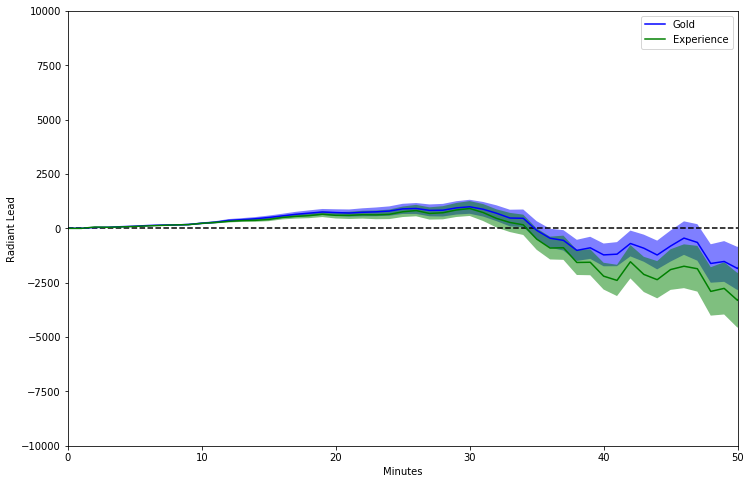

In [224]:
plt.rcParams['figure.figsize'] = [12, 8]


x = range(0,len(df.columns))
plt.axhline(y=0.5,color='k',linestyle='--')
plt.plot(x,gold_mean,'b-', label="Gold")
plt.plot(x,exp_mean,'g-', label="Experience")
plt.fill_between(x, gold_mean+gold_error, gold_mean-gold_error, facecolor='blue', alpha=0.5)
plt.fill_between(x, exp_mean+exp_error, exp_mean-exp_error, facecolor='green', alpha=0.5)
#plt.title("{2} Motif Directionality Bias {0} Motif-Thresh {1}".format(name,fimothresh,motif))
plt.ylim(-10000,10000)
plt.xlim(0,50)
plt.xlabel("Minutes")
plt.ylabel("Radiant Lead")

#xlocs = np.arange(0,maxdist,step=5)
#xlabels = [str(x) for x in (xlocs * resolution)]
#plt.xticks(xlocs,xlabels)
plt.legend()
#plt.savefig("./figs/"+name+".svg",format="svg")

plt.show()

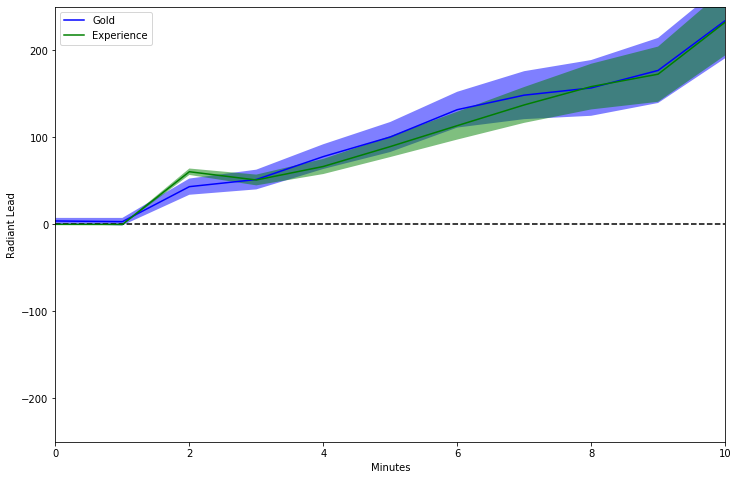

In [225]:

x = range(0,len(df.columns))
plt.axhline(y=0,color='k',linestyle='--')
plt.plot(x,gold_mean,'b-', label="Gold")
plt.plot(x,exp_mean,'g-', label="Experience")
plt.fill_between(x, gold_mean+gold_error, gold_mean-gold_error, facecolor='blue', alpha=0.5)
plt.fill_between(x, exp_mean+exp_error, exp_mean-exp_error, facecolor='green', alpha=0.5)
#plt.title("{2} Motif Directionality Bias {0} Motif-Thresh {1}".format(name,fimothresh,motif))
plt.ylim(-250,250)
plt.xlim(0,10)
plt.xlabel("Minutes")
plt.ylabel("Radiant Lead")

#xlocs = np.arange(0,maxdist,step=5)
#xlabels = [str(x) for x in (xlocs * resolution)]
#plt.xticks(xlocs,xlabels)
plt.legend()
#plt.savefig("./figs/"+name+".svg",format="svg")

plt.show()

#assuming we find an advantage we can interrogate the cause by:
1. comparing xp advantage vs gold advantage. (bounties shouldnt reflect xp, last hits won't necessarily either, only denies. and kills will influence both, probably xp more than gold)
2. comparing lane by lane stats to see if specifically lanes are the sources of the bias or whetehr it is evenly spread between them.

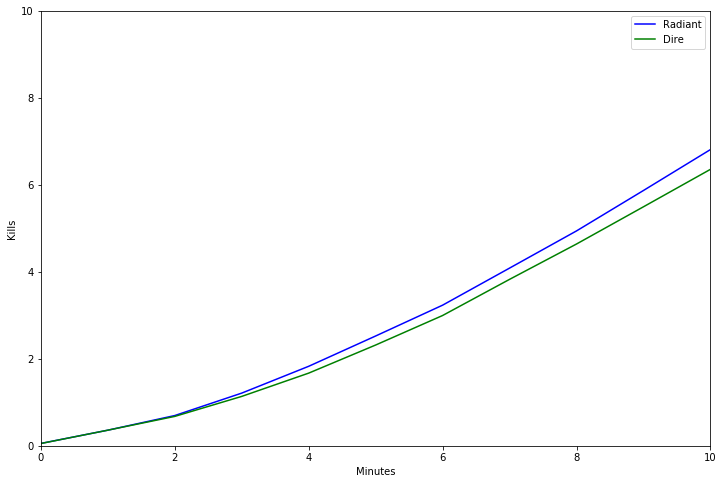

In [226]:

x = range(0,len(df.columns))
#plt.axhline(y=0.5,color='k',linestyle='--')
plt.plot(x,dk_mean.cumsum(),'b-', label="Radiant")
plt.plot(x,rk_mean.cumsum(),'g-', label="Dire")
#plt.fill_between(x, dk_mean+dk_error, dk_mean-dk_error, facecolor='blue', alpha=0.5)
#plt.fill_between(x, rk_mean+rk_error, rk_mean-rk_error, facecolor='green', alpha=0.5)
#plt.title("{2} Motif Directionality Bias {0} Motif-Thresh {1}".format(name,fimothresh,motif))
plt.ylim(0,10)
plt.xlim(0,10)
plt.xlabel("Minutes")
plt.ylabel("Kills")

#xlocs = np.arange(0,maxdist,step=5)
#xlabels = [str(x) for x in (xlocs * resolution)]
#plt.xticks(xlocs,xlabels)
plt.legend()
#plt.savefig("./figs/"+name+".svg",format="svg")

plt.show()

each deny is 1/2 a creep's xp. gives no xp or gold to denier.
Jungle creeps have slightly higher gold/xp ratio so may be part of the late game divergence. But hero kills are far larger difference and likely the cause. Should see kills increase for dire.

In [227]:
import scipy.stats

#compute lanereport summary statistics
sides = ["radiant","dire"]
lanes = ["midLane","offLane","safeLane"]
metrics = ["denyCount","meleeCount","neutralCount","rangeCount","siegeCount"]

lr_stats = {}

confidence = 0.95

for side in sides:
    for lane in lanes:
        for metric in metrics:
            slm = lanereport.xs((side,lane,metric),level=("side","lane","metric"))
            lr_stats[(side,lane,metric,"mean")] = slm.mean()
            lr_stats[(side,lane,metric,"confidence")] = slm.sem() * scipy.stats.t.ppf((1 + confidence) / 2., len(slm.index)-1)
            cumsum = slm.cumsum(axis=1)
            #print(cumsum)
            lr_stats[(side,lane,metric,"cum_mean")] = cumsum.mean()
            lr_stats[(side,lane,metric,"cum_confidence")] = cumsum.sem() * scipy.stats.t.ppf((1 + confidence) / 2., len(slm.index)-1)
            
df_lr_stats = pd.DataFrame.from_dict(lr_stats,orient='index')

df_lr_stats.index.names = ["side","lane","metric","stat"]

print(df_lr_stats)

                                                  0         1         2   \
side    lane     metric     stat                                           
radiant midLane  denyCount  mean            0.652406  0.597285  0.587824   
                            confidence      0.031365  0.029914  0.031465   
                            cum_mean        0.652406  1.249691  1.837515   
                            cum_confidence  0.031365  0.045450  0.059533   
                 meleeCount mean            1.642123  1.693953  1.626903   
...                                              ...       ...       ...   
dire    safeLane rangeCount cum_confidence  0.019195  0.028446  0.036379   
                 siegeCount mean            0.000000  0.000000  0.000000   
                            confidence      0.000000  0.000000  0.000000   
                            cum_mean        0.000000  0.000000  0.000000   
                            cum_confidence  0.000000  0.000000  0.000000   

           

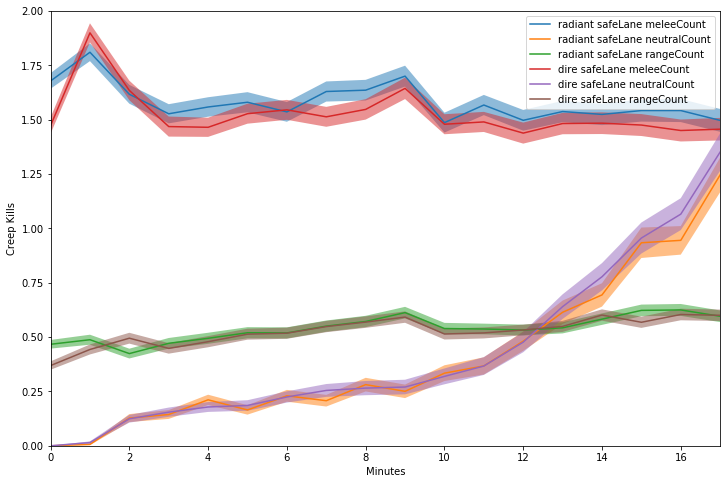

In [228]:
plot_sides = ['radiant','dire']
plot_lanes = ['safeLane']
plot_metrics = ['meleeCount','neutralCount','rangeCount']


x = range(0,len(df_lr_stats.columns))
#plt.axhline(y=0.5,color='k',linestyle='--')
for side in plot_sides:
    for lane in plot_lanes:
        for metric in plot_metrics:
            mean = df_lr_stats.xs((side,lane,metric,"mean"))
            confidence = df_lr_stats.xs((side,lane,metric,"confidence"))
            plt.plot(x,mean, label=side+" "+lane+" "+metric)
            plt.fill_between(x, mean+confidence, mean-confidence, alpha=0.5)
#plt.title("{2} Motif Directionality Bias {0} Motif-Thresh {1}".format(name,fimothresh,motif))
plt.ylim(0,2)
plt.xlim(0,17)
plt.xlabel("Minutes")
plt.ylabel("Creep Kills")

#xlocs = np.arange(0,maxdist,step=5)
#xlabels = [str(x) for x in (xlocs * resolution)]
#plt.xticks(xlocs,xlabels)
plt.legend()
#plt.savefig("./figs/"+name+".svg",format="svg")

plt.show()

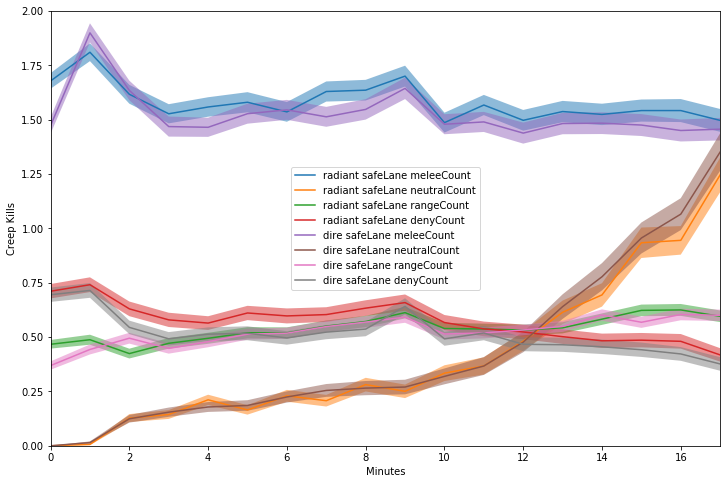

In [229]:
plot_sides = ['radiant','dire']
plot_lanes = ['safeLane']
plot_metrics = ['meleeCount','neutralCount','rangeCount','denyCount']


x = range(0,len(df_lr_stats.columns))
#plt.axhline(y=0.5,color='k',linestyle='--')
for side in plot_sides:
    for lane in plot_lanes:
        for metric in plot_metrics:
            mean = df_lr_stats.xs((side,lane,metric,"mean"))
            confidence = df_lr_stats.xs((side,lane,metric,"confidence"))
            plt.plot(x,mean, label=side+" "+lane+" "+metric)
            plt.fill_between(x, mean+confidence, mean-confidence, alpha=0.5)
#plt.title("{2} Motif Directionality Bias {0} Motif-Thresh {1}".format(name,fimothresh,motif))
plt.ylim(0,2)
plt.xlim(0,17)
plt.xlabel("Minutes")
plt.ylabel("Creep Kills")

#xlocs = np.arange(0,maxdist,step=5)
#xlabels = [str(x) for x in (xlocs * resolution)]
#plt.xticks(xlocs,xlabels)
plt.legend()
#plt.savefig("./figs/"+name+".svg",format="svg")

plt.show()

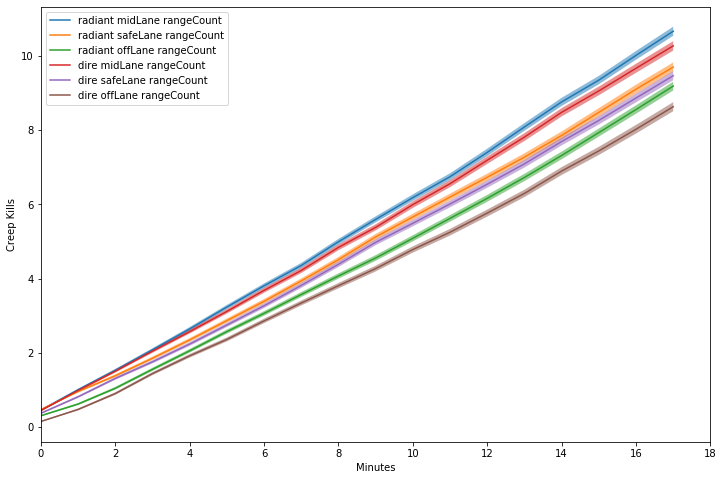

In [230]:
plot_sides = ['radiant','dire']
plot_lanes = ['midLane','safeLane','offLane']
#plot_metrics = ['meleeCount','neutralCount','denyCount']
plot_metrics = ['rangeCount']

x = range(0,len(df_lr_stats.columns))
#plt.axhline(y=0.5,color='k',linestyle='--')
for side in plot_sides:
    for lane in plot_lanes:
        for metric in plot_metrics:
            mean = df_lr_stats.xs((side,lane,metric,"cum_mean"))
            confidence = df_lr_stats.xs((side,lane,metric,"cum_confidence"))
            plt.plot(x,mean, label=side+" "+lane+" "+metric)
            plt.fill_between(x, mean+confidence, mean-confidence, alpha=0.5)
#plt.title("{2} Motif Directionality Bias {0} Motif-Thresh {1}".format(name,fimothresh,motif))
#plt.ylim(0,15)
plt.xlim(0,18)
plt.xlabel("Minutes")
plt.ylabel("Creep Kills")

#xlocs = np.arange(0,maxdist,step=5)
#xlabels = [str(x) for x in (xlocs * resolution)]
#plt.xticks(xlocs,xlabels)
plt.legend()
#plt.savefig("./figs/"+name+".svg",format="svg")

plt.show()